#### Definir como escolher os ativos:

Para definir quais ativos entram no portfólio, algumas abordagens possíveis são:

- Alta liquidez: Selecionar ativos com maior volume de negociação.
- Baixo Beta: Escolher ativos menos voláteis (se for um portfólio conservador).
- Alto Sharpe Ratio: Melhor retorno ajustado ao risco.
- P/E Ratio (Preço/Lucro): Avalia se a ação está sub ou sobrevalorizada.
- Momentum: Ativos com bom desempenho recente tendem a continuar performando bem.

In [ ]:
import yfinance as yf
import numpy as np
import time
import pandas as pd
from tqdm import tqdm

class AssetAnalyzer:
    """
    Classe para análise de ativos utilizando dados históricos do Yahoo Finance.
    
    Essa classe oferece métodos para:
      - Verificar a liquidez (volume médio) dos ativos.
      - Calcular o beta do ativo em relação a um benchmark.
      - Calcular o Sharpe Ratio.
      - Obter o P/E Ratio.
      - Calcular o momentum.
      - Processar ativos em lotes para evitar bloqueios em requisições.
    
    Por padrão, os dados são coletados para um período de 6 meses, o que permite uma análise 
    de médio prazo dos ativos. As pausas entre as requisições e entre os lotes (0.5 e 5 segundos, 
    respectivamente) são utilizadas para evitar bloqueios por excesso de requisições à API.
    """
    
    def __init__(
        self,
        tickers: list,
        period: str = "6mo",
        batch_size: int = 100,
        sleep_between_requests: float = 0.5,
        sleep_between_batches: float = 5.0
    ):
        """
        Inicializa a instância do AssetAnalyzer.
        
        Args:
            tickers (list): Lista de tickers a serem analisados.
            period (str, opcional): Intervalo de tempo para coleta dos dados (padrão "6mo").
            batch_size (int, opcional): Número de tickers a processar por lote (padrão 100).
            sleep_between_requests (float, opcional): Tempo de pausa entre requisições individuais (padrão 0.5s).
            sleep_between_batches (float, opcional): Tempo de pausa entre os lotes de requisições (padrão 5.0s).
        """
        self.tickers = tickers
        self.period = period
        self.batch_size = batch_size
        self.sleep_between_requests = sleep_between_requests
        self.sleep_between_batches = sleep_between_batches

    def get_liquidity(self, tickers: list) -> dict:
        """
        Verifica a liquidez dos ativos, calculando o volume médio de negociação.
        
        Para cada ticker, busca dados históricos (últimos 6 meses por padrão) e calcula a média 
        do volume diário. Caso os dados estejam ausentes, define o volume como zero.
        
        Args:
            tickers (list): Lista de tickers a serem verificados.
        
        Returns:
            dict: Dicionário onde a chave é o ticker e o valor é o volume médio.
        """
        liquidity = {}
        for ticker in tqdm(tickers, desc="Verificando liquidez"):
            try:
                stock = yf.Ticker(ticker)
                data = stock.history(period=self.period)
                avg_volume = data['Volume'].mean()
                liquidity[ticker] = avg_volume if avg_volume is not None else 0
                time.sleep(self.sleep_between_requests)
            except Exception as e:
                print(f"Erro ao processar {ticker}: {e}")
                liquidity[ticker] = 0
        return liquidity

    def get_beta(self, ticker: str, market_ticker: str = '^BVSP') -> float:
        """
        Calcula o beta de um ativo em relação a um índice de mercado.
        
        O beta é calculado com base nos retornos diários dos ativos e do índice, considerando 
        apenas datas em que ambos possuem dados disponíveis. Retorna None caso os dados estejam vazios.
        
        Args:
            ticker (str): Ticker do ativo.
            market_ticker (str, opcional): Ticker do índice de mercado (padrão '^BVSP').
        
        Returns:
            float: Valor do beta calculado ou None se não for possível calcular.
        """
        try:
            stock = yf.Ticker(ticker)
            market = yf.Ticker(market_ticker)
            
            stock_data = stock.history(period=self.period)['Close']
            market_data = market.history(period=self.period)['Close']
            
            if stock_data.empty or market_data.empty:
                print(f"Dados vazios para {ticker} ou {market_ticker}")
                return None
            
            # Alinhar as datas dos dados dos dois ativos
            # Remove datas com dados ausentes
            aligned_data = pd.DataFrame({
                'stock': stock_data,
                'market': market_data
            }).dropna()

            stock_returns = aligned_data['stock'].pct_change().dropna()
            market_returns = aligned_data['market'].pct_change().dropna()
            
            if stock_returns.empty or market_returns.empty:
                print(f"Retornos vazios para {ticker} ou {market_ticker}")
                return None
            
            covariance = np.cov(stock_returns, market_returns)[0][1]
            market_variance = np.var(market_returns)
            beta = covariance / market_variance
            return beta
        except Exception as e:
            print(f"Erro ao calcular beta para {ticker}: {e}")
            return None

    def get_sharpe_ratio(self, ticker: str, risk_free_rate: float = 0.06) -> float:
        """
        Calcula o Sharpe Ratio de um ativo.
        
        O Sharpe Ratio é calculado como a diferença entre o retorno médio do ativo e a taxa 
        livre de risco (ajustada para o período diário), dividido pela volatilidade dos retornos.
        
        Args:
            ticker (str): Ticker do ativo.
            risk_free_rate (float, opcional): Taxa livre de risco anual (padrão 0.06).
        
        Returns:
            float: Valor do Sharpe Ratio ou None se não for possível calcular.
        """
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(period=self.period)['Close']
            daily_returns = data.pct_change().dropna()
            
            avg_return = daily_returns.mean()
            volatility = daily_returns.std()

            sharpe_ratio = (avg_return - risk_free_rate / 252) / volatility
            return sharpe_ratio
        except Exception as e:
            print(f"Erro ao calcular Sharpe Ratio para {ticker}: {e}")
            return None

    def get_pe_ratio(self, ticker: str) -> float:
        """
        Obtém o P/E Ratio (relação preço/lucro) de um ativo.
        
        Busca o valor na propriedade 'trailingPE' disponibilizada pela API do Yahoo Finance.
        
        Args:
            ticker (str): Ticker do ativo.
        
        Returns:
            float: Valor do P/E Ratio ou None se não estiver disponível.
        """
        try:
            stock = yf.Ticker(ticker)
            pe_ratio = stock.info.get('trailingPE', None)
            return pe_ratio
        except Exception as e:
            print(f"Erro ao obter P/E Ratio para {ticker}: {e}")
            return None

    def get_momentum(self, ticker: str, period: str = None) -> float:
        """
        Calcula o momentum de um ativo.
        
        O momentum é definido como a soma das variações percentuais do fechamento dos preços ao longo do período.
        Caso o período não seja informado, utiliza o período padrão definido na instância.
        
        Args:
            ticker (str): Ticker do ativo.
            period (str, opcional): Intervalo de tempo para análise (ex: '6mo'). Se None, utiliza self.period.
        
        Returns:
            float: Valor do momentum ou None se não for possível calcular.
        """
        try:
            period_to_use = period if period is not None else self.period
            stock = yf.Ticker(ticker)
            data = stock.history(period=period_to_use)['Close']
            momentum = data.pct_change().sum()
            return momentum
        except Exception as e:
            print(f"Erro ao calcular Momentum para {ticker}: {e}")
            return None

    def process_in_batches(self) -> list:
        """
        Processa os tickers em lotes, calculando diversas métricas para cada ativo.
        
        Para cada lote:
          - Verifica a liquidez dos ativos.
          - Calcula beta, Sharpe Ratio, P/E Ratio e momentum.
          - Armazena os resultados em uma lista de dicionários.
        
        São adicionadas pausas entre os ativos e entre os lotes para evitar bloqueios nas requisições.
        
        Returns:
            list: Lista de dicionários contendo as métricas para cada ativo.
        """
        selected_assets = []
        
        # Dividindo os tickers em lotes conforme o batch_size definido
        total_batches = (len(self.tickers) + self.batch_size - 1) // self.batch_size
        for i in range(0, len(self.tickers), self.batch_size):
            batch = self.tickers[i:i+self.batch_size]
            print(f"\n🔄 Processando lote {i // self.batch_size + 1} de {total_batches}...\n")
            
            liquidity = self.get_liquidity(batch)
            
            for ticker in tqdm(batch, desc="Analisando ativos", position=0):
                try:
                    beta = self.get_beta(ticker)
                    sharpe = self.get_sharpe_ratio(ticker)
                    pe_ratio = self.get_pe_ratio(ticker)
                    momentum = self.get_momentum(ticker)
                    
                    print(f"Analisando {ticker}: Beta={beta}, Sharpe={sharpe}, PE={pe_ratio}, Momentum={momentum}")
                    
                    selected_assets.append({
                        'ticker': ticker,
                        'liquidity': liquidity[ticker],
                        'beta': beta,
                        'sharpe': sharpe,
                        'pe_ratio': pe_ratio,
                        'momentum': momentum
                    })
                    
                    time.sleep(self.sleep_between_requests)
                except Exception as e:
                    print(f"Erro ao processar {ticker}: {e}")
            
            print("⏳ Aguardando para evitar limitação...")
            time.sleep(self.sleep_between_batches)
        
        return selected_assets

# Leitura dos tickers a partir de um arquivo
with open("/workspaces/Case-H2/data/valid_tickers/valid_tickers_part_4.txt", "r") as file:
    tickers_list = [line.strip() for line in file.readlines()]

# Criação da instância do AssetAnalyzer
analyzer = AssetAnalyzer(
    tickers=tickers_list,
    period="6mo",           # Utilizando dados dos últimos 6 meses
    batch_size=100,
    sleep_between_requests=0.5,
    sleep_between_batches=5.0
)

# Processamento dos ativos em lotes
selected_assets = analyzer.process_in_batches()

# Criação do DataFrame e salvamento em CSV para análise futura
df = pd.DataFrame(selected_assets)
df.to_csv("selected_assets_5.csv", index=False)
print("\nAtivos selecionados salvos em 'selected_assets_5.csv'")

#### Medotos numericos 

Resolvendo um problema com um problema menor.

In [1]:
import pandas as pd
import numpy as np
from typing import Dict

class AssetScorer:
    def __init__(self, input_file: str, pesos: Dict[str, float]) -> None:
        """
        Inicializa a classe AssetScorer.

        :param input_file: Caminho do arquivo CSV contendo os dados dos ativos.
        :param pesos: Dicionário com os pesos das métricas para o cálculo do score.
        """
        self.input_file = input_file
        self.pesos = pesos
        self.df = pd.read_csv(input_file)

    def limpar_dados(self) -> None:
        """
        Limpa os dados, removendo duplicatas, valores infinitos e NaNs.

        Este método realiza:
        - Remoção de duplicatas com base no campo 'ticker'.
        - Substituição de valores infinitos por NaNs.
        - Remoção de linhas com valores NaNs.
        """
        self.df = (self.df.drop_duplicates(subset=['ticker'], keep='first')
                   .replace([np.inf, -np.inf], np.nan)
                   .dropna())

    def normalizar_metricas(self) -> None:
        """
        Normaliza as métricas de Sharpe, Momentum e Liquidez, e inverte a normalização para Beta e PE Ratio.

        A normalização é feita com base no valor mínimo e máximo de cada coluna:
        - Para Sharpe, Momentum e Liquidity, a normalização é feita para valores entre 0 e 1.
        - Para Beta e PE Ratio, valores menores são mais desejáveis, então a normalização é invertida.
        """
        # Normalização das métricas positivas
        for col in ["sharpe", "momentum", "liquidity"]:
            self.df[col] = (self.df[col] - self.df[col].min()) / (self.df[col].max() - self.df[col].min())

        # Invertendo a normalização para as métricas negativas (menores são melhores)
        self.df["beta"] = 1 - (self.df["beta"] - self.df["beta"].min()) / (self.df["beta"].max() - self.df["beta"].min())
        self.df["pe_ratio"] = 1 - (self.df["pe_ratio"] - self.df["pe_ratio"].min()) / (self.df["pe_ratio"].max() - self.df["pe_ratio"].min())

    def filtrar_linhas_invalidas(self) -> None:
        """
        Remove linhas onde qualquer valor de uma das métricas relevantes é igual a zero.

        Esse método garante que não existam valores de métricas nulas ou zero ao calcular o score.
        """
        self.df = self.df.loc[
            (self.df["liquidity"] != 0.000000) &
            (self.df["beta"] != 0.000000) &
            (self.df["sharpe"] != 0.000000) &
            (self.df["pe_ratio"] != 0.000000) &
            (self.df["momentum"] != 0.000000)
        ]

    def calcular_score(self) -> None:
        """
        Calcula o score de cada ativo com base nas métricas normalizadas e nos pesos definidos.

        O score é calculado pela fórmula:
        score = (sharpe * peso_sharpe) + (momentum * peso_momentum) + 
                (liquidity * peso_liquidity) + (beta * peso_beta) + 
                (pe_ratio * peso_pe_ratio)
        """
        self.df["score"] = (
            self.df["sharpe"] * self.pesos["sharpe"] +
            self.df["momentum"] * self.pesos["momentum"] +
            self.df["liquidity"] * self.pesos["liquidity"] +
            self.df["beta"] * self.pesos["beta"] +
            self.df["pe_ratio"] * self.pesos["pe_ratio"]
        )

    def ordenar_ativos(self) -> None:
        """
        Ordena os ativos pelo score calculado em ordem decrescente.

        O objetivo é classificar os ativos que possuem as melhores pontuações com base nas métricas.
        """
        self.df = self.df.sort_values(by="score", ascending=False)

    def obter_top_ativos(self, top_n: int = 10) -> pd.DataFrame:
        """
        Retorna os top N ativos com as melhores pontuações.

        :param top_n: Número de ativos a serem retornados, padrão é 10.
        :return: DataFrame contendo os top N ativos ordenados pelo score.
        """
        return self.df.head(top_n)

    def processar(self) -> pd.DataFrame:
        """
        Executa todo o processo: limpar dados, normalizar métricas, filtrar dados inválidos,
        calcular scores, ordenar os ativos e retornar os top N ativos.
        
        :return: DataFrame contendo os top ativos.
        """
        self.limpar_dados()
        self.normalizar_metricas()
        self.filtrar_linhas_invalidas()
        self.calcular_score()
        self.ordenar_ativos()
        return self.obter_top_ativos()

# Definindo os pesos das métricas
pesos = {
    "sharpe": 0.30,
    "momentum": 0.25,
    "liquidity": 0.20,
    "beta": 0.15,
    "pe_ratio": 0.10
}

# Criando uma instância da classe e processando os dados
input_file = "/workspaces/Case-H2/data/selected_assets/selected_assets_combined.csv"
scorer = AssetScorer(input_file, pesos)
df = scorer.processar()

# Exibindo os top 10 ativos com maior score
print(df)

        ticker     liquidity      beta    sharpe  pe_ratio  momentum     score
90    PDGR3.SA  1.158243e-02  1.000000  0.810190  0.999999  1.000000  0.745373
20    B3SA3.SA  1.000000e+00  0.015885  0.696462  0.997379  0.013320  0.514389
141   COGN3.SA  8.313369e-01  0.006677  0.793096  0.999298  0.017265  0.509444
6     ABEV3.SA  6.579874e-01  0.024193  0.688057  0.997390  0.012775  0.444576
92    PETR4.SA  6.023297e-01  0.026494  0.688192  0.998040  0.012478  0.433821
9     BBDC4.SA  7.654667e-01  0.018579  0.506105  0.998293  0.010443  0.410152
185   FRAS3.SA  5.579535e-03  0.022744  1.000000  0.996503  0.015783  0.408123
84    MRFG3.SA  1.566266e-01  0.024327  0.869768  0.998343  0.017790  0.400187
156  ABCP11.SA  1.540147e-05  0.034130  0.947610  0.999174  0.015116  0.393102
321  ARNC34.SA  7.245728e-07  0.034358  0.936647  0.991448  0.016647  0.389454


In [2]:
class AssetScorer:
    def __init__(self, input_file: str, pesos: Dict[str, float]) -> None:
        self.input_file = input_file
        self.pesos = pesos
        self.df = pd.read_csv(input_file)

    def limpar_dados(self) -> None:
        self.df = (self.df.drop_duplicates(subset=['ticker'], keep='first')
                   .replace([np.inf, -np.inf], np.nan)
                   .dropna())

        # Garantir que não há valores negativos em métricas que não deveriam ter
        for col in ["liquidity", "sharpe", "momentum"]:
            self.df = self.df[self.df[col] >= 0]

    def normalizar_metricas(self) -> None:
        for col in ["sharpe", "momentum", "liquidity"]:
            min_val = self.df[col].min()
            max_val = self.df[col].max()
            if min_val == max_val:
                self.df[col] = 0
            else:
                self.df[col] = (self.df[col] - min_val) / (max_val - min_val)

        self.df["beta"] = 1 - (self.df["beta"] - self.df["beta"].min()) / (self.df["beta"].max() - self.df["beta"].min())
        self.df["pe_ratio"] = 1 - (self.df["pe_ratio"] - self.df["pe_ratio"].min()) / (self.df["pe_ratio"].max() - self.df["pe_ratio"].min())

    def filtrar_linhas_invalidas(self) -> None:
        self.df = self.df.loc[
            (self.df["liquidity"] != 0.000000) &
            (self.df["beta"] != 0.000000) &
            (self.df["sharpe"] != 0.000000) &
            (self.df["pe_ratio"] != 0.000000) &
            (self.df["momentum"] != 0.000000)
        ]

    def calcular_score(self) -> None:
        self.df["score"] = (
            self.df["sharpe"] * self.pesos["sharpe"] +
            self.df["momentum"] * self.pesos["momentum"] +
            self.df["liquidity"] * self.pesos["liquidity"] +
            self.df["beta"] * self.pesos["beta"] +
            self.df["pe_ratio"] * self.pesos["pe_ratio"]
        )

    def ordenar_ativos(self) -> None:
        self.df = self.df.sort_values(by="score", ascending=False)

    def obter_top_ativos(self, top_n: int = 10) -> pd.DataFrame:
        return self.df.head(top_n)

    def processar(self) -> pd.DataFrame:
        self.limpar_dados()
        self.normalizar_metricas()
        self.filtrar_linhas_invalidas()
        self.calcular_score()
        self.ordenar_ativos()
        return self.obter_top_ativos()
    
# Definindo os pesos das métricas
pesos = {
    "sharpe": 0.30,
    "momentum": 0.25,
    "liquidity": 0.20,
    "beta": 0.15,
    "pe_ratio": 0.10
}

# Criando uma instância da classe e processando os dados
input_file = "/workspaces/Case-H2/data/selected_assets/selected_assets_combined.csv"
scorer = AssetScorer(input_file, pesos)
df = scorer.processar()

# Exibindo os top 10 ativos com maior score
print(df)

        ticker     liquidity      beta    sharpe  pe_ratio  momentum     score
90    PDGR3.SA  1.158231e-02  1.000000  0.520887  1.000000  1.000000  0.658583
141   COGN3.SA  8.313369e-01  0.006677  0.477741  0.999299  0.005630  0.411928
185   FRAS3.SA  5.579422e-03  0.022744  1.000000  0.996503  0.004130  0.405210
20    B3SA3.SA  1.000000e+00  0.015885  0.233821  0.997379  0.001638  0.372676
156  ABCP11.SA  1.528733e-05  0.034130  0.867759  0.999175  0.003456  0.366232
321  ARNC34.SA  6.104344e-07  0.034358  0.840087  0.991448  0.005004  0.357576
225  WFCO34.SA  2.761111e-04  0.034138  0.801168  0.997546  0.005384  0.346627
223  VISA34.SA  3.519468e-04  0.038106  0.786007  0.993906  0.003755  0.341918
295   MNPR3.SA  5.025042e-05  0.027350  0.788971  0.988846  0.007266  0.341505
193  ATTB34.SA  1.288752e-04  0.036632  0.783882  0.996800  0.004115  0.341394


#### Fronteira eficiente Markovitz

Harry Markowitz criou em 1952 uma teoria que analise o risco de uma carteira de investimento.\
O objetivo do modelo é criar um portifólio que otimiza o risco-retorno dos investimentos disponíveis, escolhendo os ideias pra cada ativo na carteira.

YF.download() has changed argument auto_adjust default to True
Numero de carteiras: 100000, Tabela retorno esperados: (100000,), Tabela volatilidade esperada: (100000,), Tabela shape: (100000,), Tabela pesos: (100000, 10)

Pesos atrelados aos tickers:
      ticker      peso
0   PDGR3.SA  0.201629
1   COGN3.SA  0.088169
2   FRAS3.SA  0.231888
3   B3SA3.SA  0.023731
4  ABCP11.SA  0.008210
5  ARNC34.SA  0.149776
6  WFCO34.SA  0.123782
7  VISA34.SA  0.004044
8   MNPR3.SA  0.149115
9  ATTB34.SA  0.019656


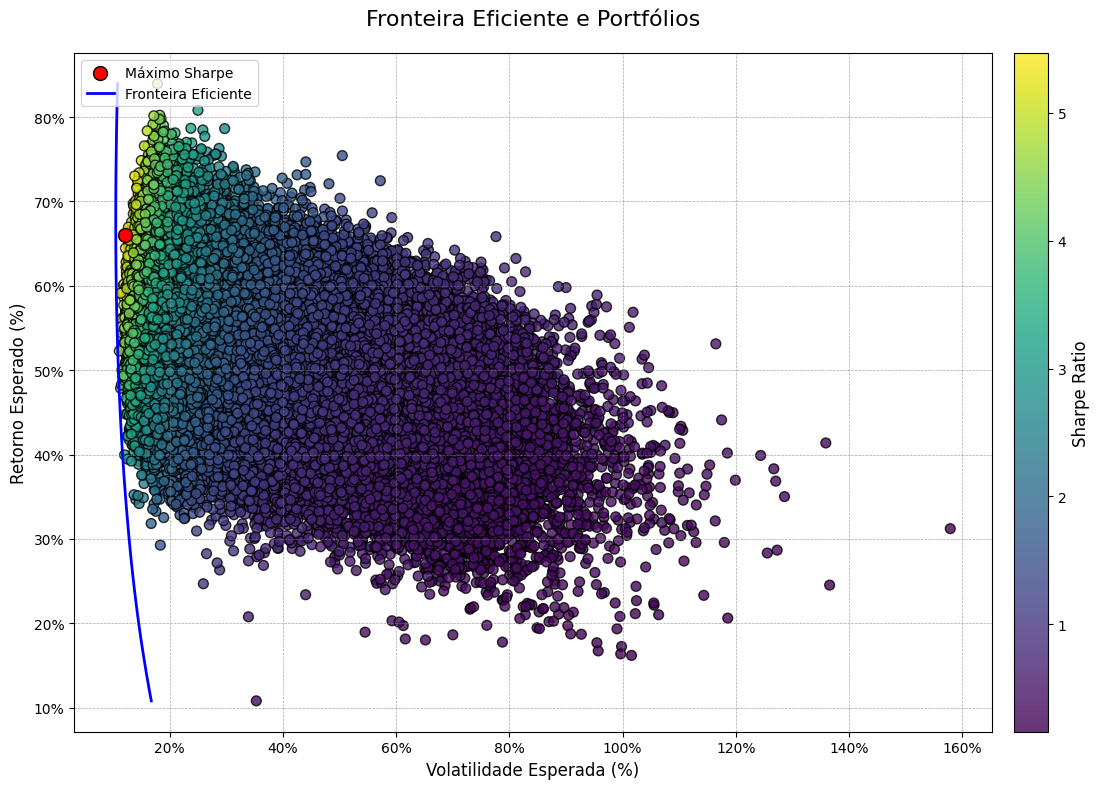

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime as dt

# Parâmetros iniciais
inicio = "2024-09-01"
fim = "2025-02-28"

# Função para obter preços ajustados de ativos
def obter_precos(tickers: list, inicio: str, fim: str) -> pd.DataFrame:
    """
    Função que baixa os preços históricos ajustados de um ou mais ativos do Yahoo Finance.

    :param tickers: Lista de símbolos de ativos para download.
    :param inicio: Data de início do histórico (formato 'AAAA-MM-DD').
    :param fim: Data final do histórico (formato 'AAAA-MM-DD').
    :return: DataFrame com os preços ajustados dos ativos.
    """
    precos = yf.download(tickers, start=inicio, end=fim, progress=False)
    if 'Adj Close' in precos.columns:
        return precos['Adj Close']
    return precos['Close']

# Função para calcular os retornos diários dos ativos
def calcular_retornos(precos: pd.DataFrame) -> pd.DataFrame:
    """
    Função que calcula os retornos diários dos ativos.

    :param precos: DataFrame com os preços ajustados dos ativos.
    :return: DataFrame com os retornos diários dos ativos.
    """
    return precos.pct_change().dropna()

# Função para calcular a média dos retornos diários
def calcular_media_retornos(retornos: pd.DataFrame) -> pd.Series:
    """
    Função que calcula a média dos retornos diários de todos os ativos.

    :param retornos: DataFrame com os retornos diários dos ativos.
    :return: Série com a média dos retornos diários.
    """
    return retornos.mean()

# Função para calcular a matriz de covariância dos retornos
def calcular_matriz_covariancia(retornos: pd.DataFrame) -> pd.DataFrame:
    """
    Função que calcula a matriz de covariância dos retornos diários.

    :param retornos: DataFrame com os retornos diários dos ativos.
    :return: DataFrame com a matriz de covariância dos retornos diários.
    """
    return retornos.cov()

# Função para gerar carteiras aleatórias
def gerar_carteiras(tickers: list, numero_carteiras: int, media_retornos: pd.Series, matriz_cov: pd.DataFrame) -> tuple:
    """
    Função que gera carteiras aleatórias com base nos retornos médios e na matriz de covariância.

    :param tickers: Lista de símbolos de ativos.
    :param numero_carteiras: Número de carteiras aleatórias a serem geradas.
    :param media_retornos: Média dos retornos diários dos ativos.
    :param matriz_cov: Matriz de covariância dos retornos dos ativos.
    :return: Tabelas com os retornos esperados, volatilidade esperada, índice de Sharpe e os pesos das carteiras.
    """
    tabela_retornos_esperados = np.zeros(numero_carteiras)
    tabela_volatilidade_esperadas = np.zeros(numero_carteiras)
    tabela_shape = np.zeros(numero_carteiras)
    tabela_pesos = np.zeros((numero_carteiras, len(tickers)))
    print(f"Numero de carteiras: {numero_carteiras}, Tabela retorno esperados: {tabela_retornos_esperados.shape}, Tabela volatilidade esperada: {tabela_volatilidade_esperadas.shape}, Tabela shape: {tabela_shape.shape}, Tabela pesos: {tabela_pesos.shape}")
    
    for i in range(numero_carteiras):
        pesos = np.random.random(len(tickers))  # Geração aleatória de pesos
        pesos /= np.sum(pesos)  # Normaliza para que a soma dos pesos seja 1
        tabela_pesos[i, :] = pesos
        
        # Calculando o retorno esperado anualizado
        tabela_retornos_esperados[i] = np.sum(pesos * media_retornos * 252)
        
        # Calculando a volatilidade anualizada (desvio padrão)
        tabela_volatilidade_esperadas[i] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov * 252, pesos)))
        
        # Calculando o índice de Sharpe
        tabela_shape[i] = tabela_retornos_esperados[i] / tabela_volatilidade_esperadas[i]
    
    return tabela_retornos_esperados, tabela_volatilidade_esperadas, tabela_shape, tabela_pesos

# Função para encontrar o portfólio com o melhor índice de Sharpe
def portifolio_com_sharpe_maximo(tabela_shape: np.ndarray, tabela_pesos: np.ndarray) -> np.ndarray:
    """
    Função para identificar o portfólio com o maior índice de Sharpe.

    :param tabela_shape: Array com os índices de Sharpe de todas as carteiras.
    :param tabela_pesos: Array com os pesos das carteiras.
    :return: Pesos do portfólio com o maior índice de Sharpe.
    """
    indice_do_sharpe_maximo = tabela_shape.argmax()
    tabela_shape_maximo = tabela_pesos[indice_do_sharpe_maximo]
    return tabela_shape_maximo

# Função para calcular o retorno de um portfólio dado seus pesos
def pegando_retorno(peso_teste: np.ndarray, media_retornos: pd.Series) -> float:
    """
    Função que calcula o retorno de um portfólio com base nos pesos dos ativos.

    :param peso_teste: Pesos dos ativos no portfólio.
    :param media_retornos: Média dos retornos diários dos ativos.
    :return: Retorno do portfólio anualizaso.
    """
    retorno = np.sum(peso_teste * media_retornos * 252)
    retorno = np.exp(retorno) - 1
    return retorno

# Função para verificar se a soma dos pesos é igual a 1
def checando_soma_pesos(peso_teste: np.ndarray) -> float:
    """
    Função que verifica se a soma dos pesos de um portfólio é igual a 1.

    :param peso_teste: Pesos dos ativos no portfólio.
    :return: A diferença entre a soma dos pesos e 1.
    """
    soma_pesos = np.sum(peso_teste) - 1
    return soma_pesos

# Função para calcular a volatilidade (risco) de um portfólio
def pegando_vol(peso_teste: np.ndarray, matriz_cov: pd.DataFrame) -> float:
    """
    Função que calcula a volatilidade de um portfólio com base nos pesos e na matriz de covariância.

    :param peso_teste: Pesos dos ativos no portfólio.
    :param matriz_cov: Matriz de covariância dos retornos dos ativos.
    :return: Volatilidade anualizada do portfólio.
    """
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov * 252, peso_teste)))
    return vol

# Função para construir a fronteira eficiente
def construir_fronteira_eficiente(eixo_y_fronteira_eficiente: np.ndarray, peso_inicial: np.ndarray, limites: tuple,
                                   media_retornos: pd.Series, matriz_cov: pd.DataFrame) -> list:
    """
    Função que constrói a fronteira eficiente utilizando a otimização.

    :param eixo_y_fronteira_eficiente: Eixo Y (retornos) da fronteira eficiente.
    :param peso_inicial: Pesos iniciais para o portfólio.
    :param limites: Limites para os pesos dos ativos.
    :param media_retornos: Média dos retornos diários dos ativos.
    :param matriz_cov: Matriz de covariância dos retornos dos ativos.
    :return: Eixo X (volatilidade) da fronteira eficiente.
    """
    eixo_x_fronteira_eficiente = []
    
    for retorno_possivel in eixo_y_fronteira_eficiente:
        restricoes = (
            {'type': 'eq', 'fun': checando_soma_pesos},
            {'type': 'eq', 'fun': lambda w: pegando_retorno(w, media_retornos) - retorno_possivel}
        )
        # Passar matriz_cov como argumento adicional
        resultado = minimize(pegando_vol, peso_inicial, args=(matriz_cov,), method='SLSQP', bounds=limites, constraints=restricoes)
        eixo_x_fronteira_eficiente.append(resultado.fun)
    
    return eixo_x_fronteira_eficiente

# Função para plotar a fronteira eficiente com melhorias
def plotar_fronteira_efficient(tabela_volatilidade_esperadas, tabela_retornos_esperados, tabela_shape, eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Scatter plot dos dados
    scatter = ax.scatter(
        tabela_volatilidade_esperadas, 
        tabela_retornos_esperados, 
        c=tabela_shape, 
        cmap='viridis', 
        edgecolor='k', 
        s=50,  # Tamanho dos pontos
        alpha=0.8  # Transparência
    )

    # Configurar os rótulos dos eixos
    ax.set_xlabel('Volatilidade Esperada (%)', fontsize=12, color='black')
    ax.set_ylabel('Retorno Esperado (%)', fontsize=12, color='black')

    # Destacar o ponto com o maior Sharpe Ratio
    indice_do_sharpe_maximo = tabela_shape.argmax()
    ax.scatter(
        tabela_volatilidade_esperadas[indice_do_sharpe_maximo], 
        tabela_retornos_esperados[indice_do_sharpe_maximo], 
        color='red', 
        edgecolor='k', 
        s=100, 
        label='Máximo Sharpe', 
        zorder=5
    )

    # Plotar a fronteira eficiente
    ax.plot(
        eixo_x_fronteira_eficiente, 
        eixo_y_fronteira_eficiente, 
        label='Fronteira Eficiente', 
        color='blue', 
        linewidth=2
    )

    # Formatar os eixos como porcentagem
    import matplotlib.ticker as mticker
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Alterar cores e tamanhos dos ticks
    ax.tick_params(axis='x', colors='black', labelsize=10)
    ax.tick_params(axis='y', colors='black', labelsize=10)

    # Adicionar uma barra de cores para o scatter plot
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
    cbar.set_label('Sharpe Ratio', fontsize=12, color='black')
    cbar.ax.yaxis.set_tick_params(color='black', labelsize=10)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

    # Adicionar título ao gráfico
    ax.set_title('Fronteira Eficiente e Portfólios', fontsize=16, color='black', pad=20)

    # Adicionar legenda
    ax.legend(fontsize=10, loc='upper left')

    # Adicionar grade para facilitar a leitura
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Exibir o gráfico
    plt.tight_layout()
    plt.show()

# Atualizar a função principal
def main(df: pd.DataFrame) -> None:
    tickers = df['ticker'].tolist()
    precos = obter_precos(tickers, inicio, fim)
    retornos = calcular_retornos(precos)

    # Calcular a média dos retornos e a matriz de covariância
    media_retornos = calcular_media_retornos(retornos)
    matriz_cov = calcular_matriz_covariancia(retornos)

    # Gerar carteiras aleatórias
    numero_carteiras = 100000
    tabela_retornos_esperados, tabela_volatilidade_esperadas, tabela_shape, tabela_pesos = \
        gerar_carteiras(tickers, numero_carteiras, media_retornos, matriz_cov)

    # Encontrar o portfólio com o melhor índice de Sharpe
    pesos_sharpe_maximo = portifolio_com_sharpe_maximo(tabela_shape, tabela_pesos)

    # Garantir que os pesos estão atrelados aos tickers corretamente
    assert len(tickers) == len(pesos_sharpe_maximo), "Erro: O número de tickers não corresponde ao número de pesos!"

    # Criar um DataFrame com os tickers e os pesos
    pesos_df = pd.DataFrame({
        'ticker': tickers,
        'peso': pesos_sharpe_maximo
    })

    # Exibir os pesos atrelados aos tickers
    print("\nPesos atrelados aos tickers:")
    print(pesos_df)

    # Salvar os pesos em um arquivo CSV
    pesos_df.to_csv("pesos_portfolio.csv", index=False)

    # Construir a fronteira eficiente
    eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados.min(), tabela_retornos_esperados.max(), 50)
    peso_inicial = [1 / len(tickers)] * len(tickers)
    limites = tuple([(0, 1)] * len(tickers))
    eixo_x_fronteira_eficiente = construir_fronteira_eficiente(
        eixo_y_fronteira_eficiente, peso_inicial, limites, media_retornos, matriz_cov)

    # Chamar a função para plotar o gráfico
    plotar_fronteira_efficient(
        tabela_volatilidade_esperadas, 
        tabela_retornos_esperados, 
        tabela_shape, 
        eixo_x_fronteira_eficiente, 
        eixo_y_fronteira_eficiente
    )

# Chamada da função principal
if __name__ == "__main__":
    main(df)

#### Prevendo performance futura com Machine Learning

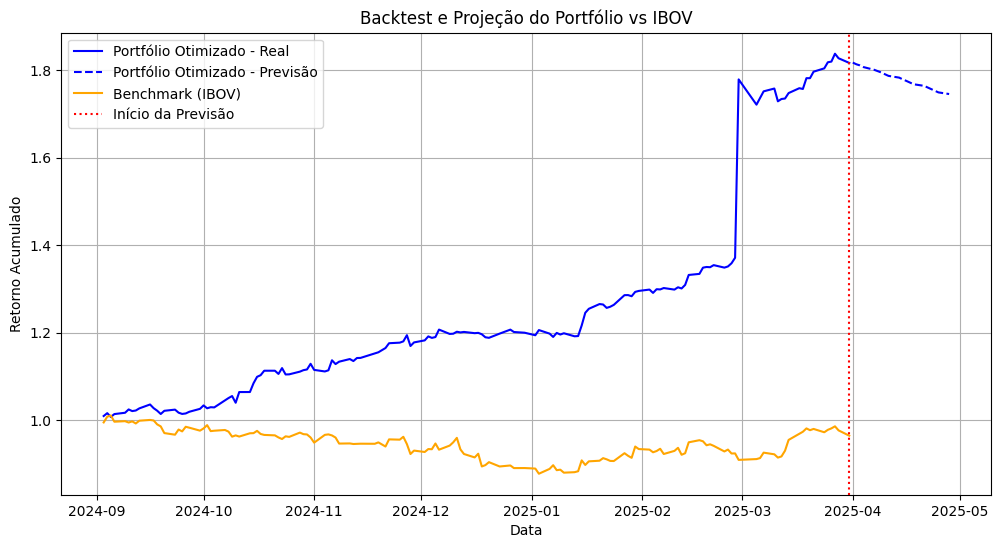

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suprimir todos os warnings
warnings.filterwarnings("ignore")

# Seu código permanece o mesmo

# Período de backtest
inicio_backtest = "2024-09-01"
fim_backtest = "2025-04-01"

# Carregar os pesos e tickers do arquivo CSV
pesos_df = pd.read_csv("/workspaces/Case-H2/notebook/pesos_portfolio.csv")
tickers = pesos_df['ticker'].tolist()  # Lista de tickers
pesos_otimizados = pesos_df['peso'].values  # Array de pesos

# Baixar dados históricos
dados_backtest = yf.download(tickers, start=inicio_backtest, end=fim_backtest, progress=False)['Close']

# Calcular retornos diários
#retornos_diarios = dados_backtest.pct_change()

# Calcular retornos diários manualmente
retornos_diarios = dados_backtest.copy()  # Copiar os dados históricos
for ticker in tickers:
    retornos_diarios[ticker] = (dados_backtest[ticker] - dados_backtest[ticker].shift(1)) / dados_backtest[ticker].shift(1)

# Remover valores NaN gerados no primeiro dia
retornos_diarios = retornos_diarios.dropna()

# Número de dias para prever
dias_para_prever = 20

# Previsões dos ativos usando ARIMA
previsoes_ativos = []
for ticker in tickers:
    retornos_ativo = retornos_diarios[ticker]
    modelo = ARIMA(retornos_ativo, order=(5,1,0))
    modelo_ajustado = modelo.fit()
    previsao = modelo_ajustado.forecast(steps=dias_para_prever)
    previsoes_ativos.append(previsao)

# Converter previsões para um array numpy
previsoes_ativos = np.array(previsoes_ativos)

# Criar índice de datas para previsões
datas_previsao = pd.date_range(start=dados_backtest.index[-1] + pd.Timedelta(days=1), 
                               periods=dias_para_prever, freq='B')

# Criar série temporal para os retornos previstos do portfólio
retorno_portfolio_estimado = np.dot(pesos_otimizados, previsoes_ativos)
retorno_portfolio_estimado = pd.Series(retorno_portfolio_estimado, index=datas_previsao)

# Baixar dados do benchmark (IBOV)
benchmark = yf.download('^BVSP', start=inicio_backtest, end=fim_backtest, progress=False)['Close']
retorno_benchmark = benchmark.pct_change().dropna()

# Calcular retornos acumulados
retorno_acumulado_portfolio_real = (1 + retornos_diarios.dot(pesos_otimizados)).cumprod()

# **Correção: ajustar a previsão para começar do último valor real**
ultimo_valor_real = retorno_acumulado_portfolio_real.iloc[-1]
retorno_acumulado_portfolio_previsto = (1 + retorno_portfolio_estimado).cumprod() * ultimo_valor_real

# Calcular retorno acumulado do IBOV
retorno_acumulado_benchmark = (1 + retorno_benchmark).cumprod()

# Garantir alinhamento dos índices
retorno_acumulado_benchmark = retorno_acumulado_benchmark.reindex(retorno_acumulado_portfolio_real.index, method='ffill')

# Obter taxa Selic diária e calcular retorno acumulado
selic_anual = 13.75 / 100  
selic_diaria = (1 + selic_anual) ** (1 / 252) - 1
retorno_selic = pd.Series(selic_diaria, index=retorno_acumulado_portfolio_real.index)
retorno_acumulado_selic = (1 + retorno_selic).cumprod()

# **Correção: Concatenação correta das séries real e prevista**
retorno_acumulado_portfolio = pd.concat([retorno_acumulado_portfolio_real, retorno_acumulado_portfolio_previsto])

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(retorno_acumulado_portfolio_real, label="Portfólio Otimizado - Real", color="blue")
plt.plot(retorno_acumulado_portfolio_previsto, label="Portfólio Otimizado - Previsão", color="blue", linestyle="dashed")
plt.plot(retorno_acumulado_benchmark, label="Benchmark (IBOV)", color="orange")
#plt.plot(retorno_acumulado_selic, label="Selic Acumulada", color="green", linestyle="--")

# Adicionar linha vertical indicando o ponto de transição
plt.axvline(x=retorno_acumulado_portfolio_real.index[-1], color='red', linestyle='dotted', label="Início da Previsão")

plt.title("Backtest e Projeção do Portfólio vs IBOV")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.grid()
plt.show()

# Olha o ação que teve um pico

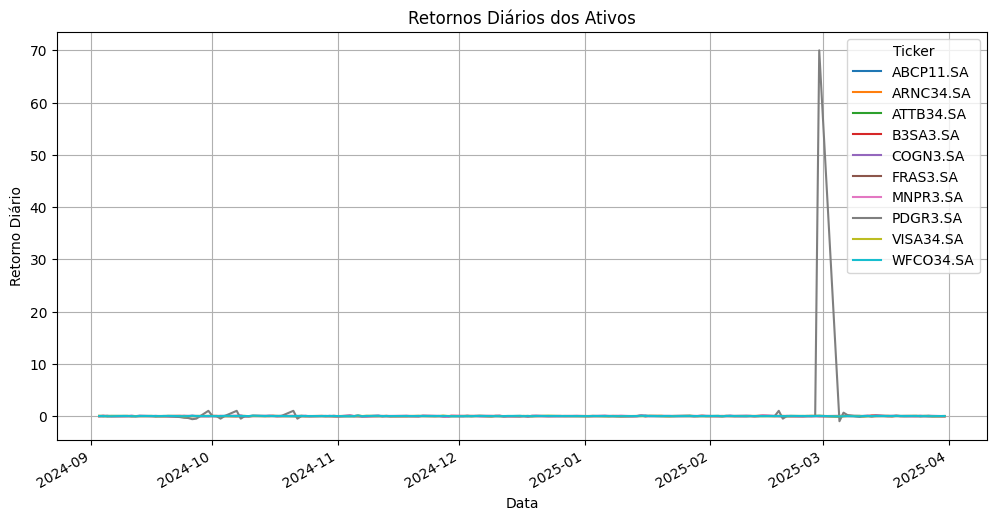

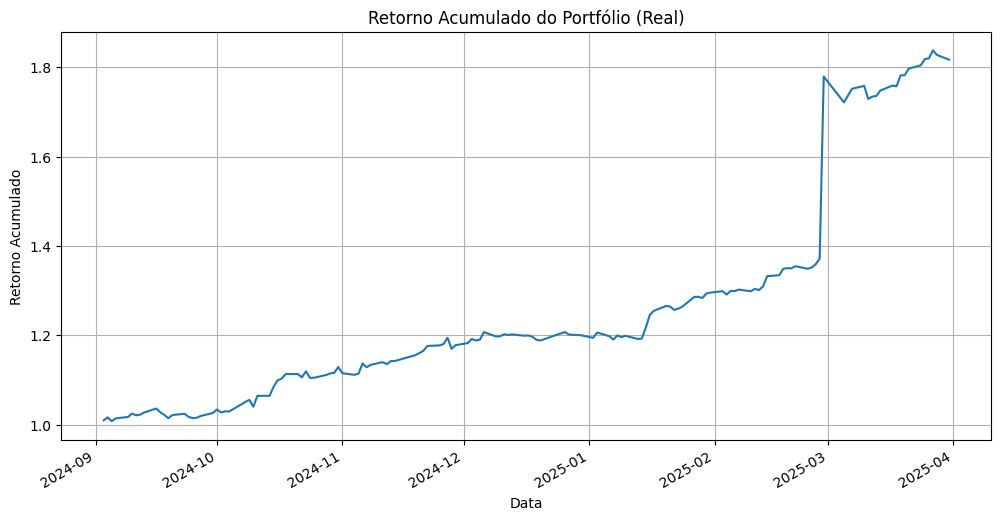

In [9]:
# Gráfico dos retornos diários
retornos_diarios.plot(figsize=(12, 6), title="Retornos Diários dos Ativos")
plt.xlabel("Data")
plt.ylabel("Retorno Diário")
plt.grid()
plt.show()

# Gráfico do retorno acumulado
retorno_acumulado_portfolio_real.plot(figsize=(12, 6), title="Retorno Acumulado do Portfólio (Real)")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.grid()
plt.show()

#### Carteira final

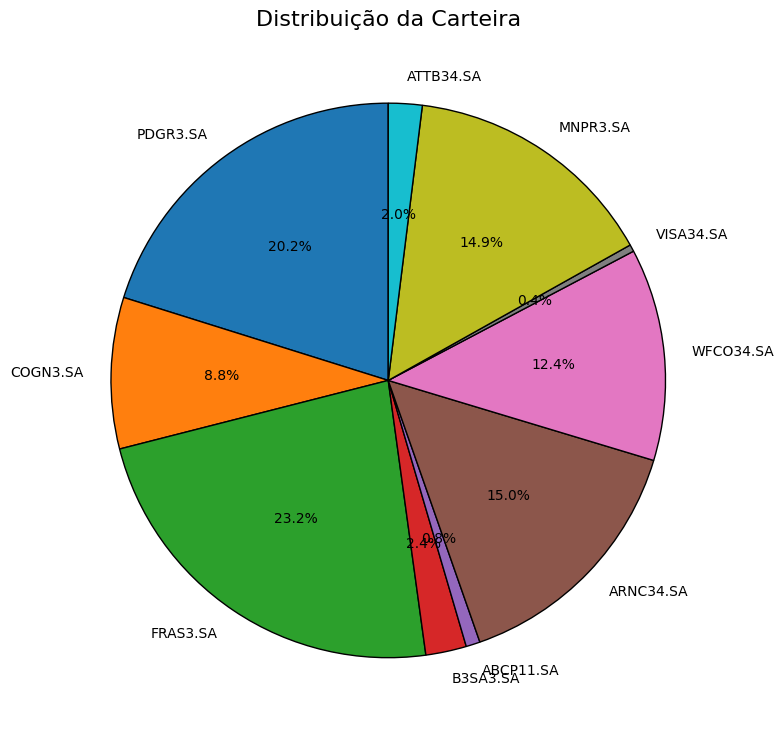

In [10]:
import matplotlib.pyplot as plt

# Carregar os pesos e tickers do arquivo CSV
pesos_df = pd.read_csv("/workspaces/Case-H2/notebook/pesos_portfolio.csv")
tickers = pesos_df['ticker'].tolist()  # Lista de tickers
pesos = pesos_df['peso'].values  # Array de pesos

# Criar o gráfico de pizza
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    pesos, 
    labels=tickers, 
    autopct='%1.1f%%',  # Mostrar porcentagens
    startangle=90,  # Começar o gráfico no ângulo de 90 graus
    colors=plt.cm.tab10.colors,  # Paleta de cores
    wedgeprops={'edgecolor': 'black'}  # Adicionar bordas às fatias
)

# Adicionar título
ax.set_title('Distribuição da Carteira', fontsize=16)

# Exibir o gráfico
plt.tight_layout()
plt.show()

#### Code UTILS

In [ ]:
from investpy import get_stocks_list
import yfinance as yf
import time
from tqdm import tqdm  


def check_tickers(ticker_list):
    """
    Verifica quais tickers estão disponíveis no Yahoo Finance.

    A função tenta obter os dados históricos diários de cada ticker na lista fornecida. 
    Se os dados forem encontrados, o ticker é considerado válido e é adicionado à lista 
    de tickers disponíveis. Caso contrário, o ticker é ignorado. 
    A verificação é feita através da API do `yfinance`.

    Args:
        ticker_list (list): Lista de tickers a serem verificados.

    Returns:
        list: Lista contendo os tickers válidos disponíveis no Yahoo Finance.

    Exemplo:
        ticker_list = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA']
        valid_tickers = check_tickers(ticker_list)
        print(valid_tickers)  # ['PETR4.SA', 'VALE3.SA']
        
    Processo:
        1. Para cada ticker na lista, a função tenta consultar os dados históricos diários.
        2. Se os dados forem encontrados e não estiverem vazios, o ticker é adicionado à lista de válidos.
        3. Se houver algum erro durante a consulta (ex: ticker inválido ou indisponível), o erro será tratado e o ticker será ignorado.
        4. A cada requisição, a função faz uma pausa de 0.5 segundos para evitar bloqueios por excesso de requisições.

    Observações:
        - A função não realiza cálculos financeiros. Ela apenas verifica a disponibilidade de dados.
        - A pausa de 0.5 segundos entre requisições é uma medida para prevenir bloqueios do Yahoo Finance por excesso de requisições.
        - Em caso de erro ao tentar acessar um ticker, o erro é capturado e o ticker é ignorado, sem interromper o processamento dos demais.
    """
    available_tickers = []
    
    # Itera sobre a lista de tickers para verificar sua disponibilidade no Yahoo Finance
    for ticker in tqdm(ticker_list, desc="Verificando tickers"):
        try:
            # Tenta obter os dados históricos diários do ticker
            stock = yf.Ticker(ticker)
            hist = stock.history(period="1d")
            
            # Verifica se os dados não estão vazios
            if not hist.empty:
                available_tickers.append(ticker)
        except Exception as e:
            # Em caso de erro (ex: ticker inválido), imprime o erro e continua com o próximo ticker
            print(f"Erro ao verificar {ticker}: {e}")
        
        # Evita bloqueio por excesso de requisições ao servidor, fazendo uma pausa de 0.5 segundos
        time.sleep(0.5) 
    
    # Retorna a lista com os tickers válidos
    return available_tickers


br_tickers = get_stocks_list(country="brazil")
br_tickers_yf = [ticker + ".SA" for ticker in br_tickers]


valid_tickers = check_tickers(br_tickers_yf)

with open("valid_tickers.txt", "w") as file:
    for ticker in valid_tickers:
        file.write(ticker + "\n")
print("\nTickers disponíveis salvos em 'valid_tickers.txt'.")

with open("valid_tickers.txt", "r") as file:
    saved_tickers = [line.strip() for line in file.readlines()]
print("\nTickers lidos do arquivo:", saved_tickers)


In [ ]:
class TickerSplitter:
    def __init__(self, input_file: str, num_parts: int = 4) -> None:
        """
        Inicializa a classe TickerSplitter.

        Args:
            input_file (str): Caminho para o arquivo de entrada contendo os tickers.
            num_parts (int): Número de partes em que os tickers devem ser divididos. O valor padrão é 4.
        """
        self.input_file = input_file
        self.num_parts = num_parts
        self.tickers = []
        self.chunks = []

    def read_tickers(self) -> None:
        """
        Lê os tickers do arquivo de entrada e armazena na lista `self.tickers`.

        O arquivo de entrada deve conter um ticker por linha.
        """
        try:
            with open(self.input_file, "r") as file:
                self.tickers = file.readlines()
            print(f"{len(self.tickers)} tickers lidos do arquivo {self.input_file}.")
        except FileNotFoundError:
            print(f"Erro: o arquivo {self.input_file} não foi encontrado.")
    
    def split_tickers(self) -> None:
        """
        Divide a lista de tickers em partes iguais.

        A lista de tickers é dividida em `self.num_parts` partes. Se o número de tickers não
        for divisível por `num_parts`, as partes são ajustadas para garantir que todos os tickers
        sejam distribuídos corretamente.
        """
        if len(self.tickers) == 0:
            print("Nenhum ticker para dividir. Certifique-se de que o arquivo foi lido corretamente.")
            return

        # Calcula o tamanho de cada parte (chunk)
        chunk_size = len(self.tickers) // self.num_parts
        self.chunks = [self.tickers[i:i + chunk_size] for i in range(0, len(self.tickers), chunk_size)]

        # Garantir que todos os tickers sejam distribuídos, ajustando o número de partes
        if len(self.chunks) > self.num_parts:
            self.chunks[-2].extend(self.chunks[-1])
            self.chunks = self.chunks[:-1]

        print(f"A lista de tickers foi dividida em {len(self.chunks)} partes.")

    def save_chunks(self) -> None:
        """
        Salva cada parte da lista de tickers em arquivos separados.

        Cada parte é salva em um arquivo no formato `valid_tickers_part_{i}.txt`.
        """
        for i, chunk in enumerate(self.chunks):
            with open(f"valid_tickers_part_{i + 1}.txt", "w") as file:
                file.writelines(chunk)
            print(f"Parte {i + 1} salva em 'valid_tickers_part_{i + 1}.txt'.")

    def process(self) -> None:
        """
        Executa todo o processo: ler os tickers, dividir em partes e salvar os arquivos.

        Este método executa as três etapas de uma vez: leitura dos tickers, divisão em partes e
        salvamento das partes em arquivos separados.
        """
        self.read_tickers()
        self.split_tickers()
        self.save_chunks()

ticker_splitter = TickerSplitter(input_file="valid_tickers.txt", num_parts=4)
ticker_splitter.process()


In [ ]:
import pandas as pd
import os
from typing import List

class CSVCombiner:
    def __init__(self, folder_path: str, output_file: str) -> None:
        """
        Inicializa a classe CSVCombiner.

        :param folder_path: Caminho da pasta onde os arquivos CSV estão localizados.
        :param output_file: Caminho para o arquivo de saída onde o DataFrame combinado será salvo.
        """
        self.folder_path = folder_path
        self.output_file = output_file

    def list_csv_files(self) -> List[str]:
        """
        Lista todos os arquivos CSV na pasta especificada.

        :return: Lista de caminhos completos para os arquivos CSV.
        """
        arquivos_csv = [os.path.join(self.folder_path, arquivo) 
                        for arquivo in os.listdir(self.folder_path) 
                        if arquivo.endswith(".csv")]
        return arquivos_csv

    def read_csv_files(self, arquivos_csv: List[str]) -> List[pd.DataFrame]:
        """
        Lê todos os arquivos CSV e os converte em DataFrames.

        :param arquivos_csv: Lista de caminhos completos para os arquivos CSV.
        :return: Lista de DataFrames lidos dos arquivos CSV.
        """
        dataframes = [pd.read_csv(arquivo) for arquivo in arquivos_csv]
        return dataframes

    def combine_dataframes(self, dataframes: List[pd.DataFrame]) -> pd.DataFrame:
        """
        Combina todos os DataFrames em um único DataFrame.

        :param dataframes: Lista de DataFrames a serem combinados.
        :return: DataFrame combinado.
        """
        df_completo = pd.concat(dataframes, ignore_index=True)
        return df_completo

    def save_combined_df(self, df_completo: pd.DataFrame) -> None:
        """
        Salva o DataFrame combinado em um arquivo CSV.

        :param df_completo: DataFrame a ser salvo.
        """
        df_completo.to_csv(self.output_file, index=False)

    def process(self) -> None:
        """
        Executa todo o processo: listar arquivos, ler, combinar e salvar.
        """
        arquivos_csv = self.list_csv_files()
        dataframes = self.read_csv_files(arquivos_csv)
        df_completo = self.combine_dataframes(dataframes)
        self.save_combined_df(df_completo)
        print(f"Arquivo combinado salvo em {self.output_file}")

# Uso da classe CSVCombiner
folder_path = "/workspaces/Case-H2/data/selected_assets"
output_file = "/workspaces/Case-H2/data/selected_assets_combined.csv"

# Criar instância e rodar o processo
combiner = CSVCombiner(folder_path, output_file)
combiner.process()